In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Initial Conditions are not known
#Initial value of (x,y,z) is a joint Gaussian with mean (1,1,1) and covariance of identity matrix. 

Mean=np.array([1,1,1]).reshape(3,1)
Cov=np.array([[1,0,0],[0,1,0],[0,0,1]])
print(Mean.shape)
print(Cov.shape)

# Define dimension. 
d = 3


(3, 1)
(3, 3)


In [10]:
#Checking the eigen value of Covariance Matrix, to verify if it is a positive definite matrix
np.linalg.eigvals(Cov)

array([1., 1., 1.])

*Sampling* Reference:

https://juanitorduz.github.io/multivariate_normal/

Isocontours:

http://cs229.stanford.edu/section/gaussians.pdf

In [12]:
epsilon = 0.0001

# Add small pertturbation
K = Cov+ epsilon*np.identity(d)

#To calculate the Lower Triangular Matrix
L = np.linalg.cholesky(K)
print(L)

#To demonstrates that code was able to get a lower traingular matrix as is expected in Cholesky Decomposition

print(np.dot(L, np.transpose(L)))


#Scale =1 means Identity Matrix multiplied with the value.

#n refers to number of samples to be extracted from the Joint Gaussian

n = 10000

u = np.random.normal(loc=0, scale=1, size=d*n).reshape(d, n)

#Extracting 10000 samples from the Joint Gaussian for each Random Vector [X,Y,Z]
f= Mean + np.dot(L, u)


[[1.00005 0.      0.     ]
 [0.      1.00005 0.     ]
 [0.      0.      1.00005]]
[[1.0001 0.     0.    ]
 [0.     1.0001 0.    ]
 [0.     0.     1.0001]]


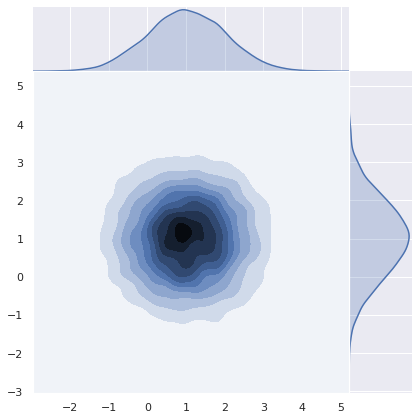

In [14]:
#Plotting the Initial Values Sample for Random Vector X and Y
sns.jointplot(x=f[0],
              y=f[1], 
              kind="kde", 
              space=0);

In [15]:
#Solving with Runge Kutta Order-4
# Size of K1 is 3*100, i.e 100 iterations of each Random Vector X,Y,Z
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

k1=np.zeros((3,100))
k2=np.zeros((3,100))
k3=np.zeros((3,100))
k4=np.zeros((3,100))
x=np.zeros((100))
y=np.zeros((100))
z=np.zeros((100))

#Consider 4 different time steps h=np.array([0.0001,0.001,0.01,0.1]), and 10000 different intial condition coming from sampling done above.
#Consolidating all x values for each time step and each intial condition
X=np.zeros((4,10000,100))
Y=np.zeros((4,10000,100))
Z=np.zeros((4,10000,100))

In [16]:
#Function to calculate derivatives
def model(a,b,c):
  dx_dt=(10*(b-a))
  dy_dt=(a*(28-c)-b)
  dz_dt=((a*b-((8/3)*c)))
  return dx_dt,dy_dt,dz_dt

In [18]:
# Function to calculate the K1, K2, K3 and K4  for three random vectors [X,Y,Z]
def imp(i,h):
 k1[0][i],k1[1][i],k1[2][i]=model(x[i],y[i],z[i])
 k2[0][i],k2[1][i],k2[2][i]=model(x[i]+(k1[0][i]*h/2),y[i]+(k1[1][i]*h/2),z[i]+(k1[2][i]*h/2))
 k3[0][i],k3[1][i],k3[2][i]=model(x[i]+(k2[0][i]*h/2),y[i]+(k2[1][i]*h/2),z[i]+(k2[2][i]*h/2))
 k4[0][i],k4[1][i],k4[2][i]=model(x[i]+(k3[0][i]*h),y[i]+(k3[1][i]*h),z[i]+(k3[2][i]*h))
 x[i+1]=x[i]+((k1[0][i]+ 2*k2[0][i]+2*k3[0][i]+k4[0][i])/6)*h
 y[i+1]=y[i]+((k1[1][i]+ 2*k2[1][i]+2*k3[1][i]+k4[1][i])/6)*h
 z[i+1]=z[i]+((k1[2][i]+ 2*k2[2][i]+2*k3[2][i]+k4[2][i])/6)*h

In [19]:
# To Iterate for each of 10000 Initial Condition 
for p in range(0,9999):
  x[0]=f[0][p]
  y[0]=f[1][p]
  z[0]=f[2][p]
  h=np.array([0.0005,0.001,0.01,0.1])
  # To Iterate for each of the 4 time steps
  for k in range(0,3):
  # Iterating 100 times (t_initial = 0s to t_final = 100s) for 1 timestep and 1 Intial Condition
    for i in range(0,99):
      imp(i,h[k])
      X[k][p]=x
      Y[k][p]=y
      Z[k][p]=z

In [20]:
#Plotting Solutions of Differential Equation x. For Time Step H=0.001 against sampled initial condition.

#Can plot Solutions for all the different Time Steps similarly 
#fg, axes=plt.subplots(4, figsize=(10,10))

#for p in range(0,99):
  #axes[0].plot(X[0][p])

#for p in range(0,99):
  #axes[1].plot(X[1][p])

#for p in range(0,99):
  #axes[2].plot(X[2][p])

#for p in range(0,99):
  #axes[3].plot(X[3][p])

In [21]:
#Developing Probability Distribution of the Random Vector X,Y,Z
# xpdf stores value of X at 100 time instances for each random initial condition for each step size, likewise ypdf and zpdf.

xpdf=np.zeros((4,1000000))
ypdf=np.zeros((4,1000000))
zpdf=np.zeros((4,1000000))


mean=np.zeros((4,3,1))
covariance=np.zeros((4,3,3))
#CL stores covariance after adding minor disturbance values
CL=np.zeros((4,3,3))

#Lower Triangular Matrix
L=np.zeros((4,3,3))

#Random samples from standard normal probability distribution
U=np.zeros((3,10000))

#Stores probability distribution for actual X,Y and Z
F=np.zeros((4,3,10000))

U=np.random.normal(loc=0, scale=1, size=d*n).reshape(d, n)

for i in range(0,3):
  xpdf[i]=X[i][:].reshape(1,1000000).flatten()
  ypdf[i]=Y[i][:].reshape(1,1000000).flatten()
  zpdf[i]=Z[i][:].reshape(1,1000000).flatten()
  mean[i]=np.array([xpdf[i].mean(),ypdf[i].mean(),zpdf[i].mean()]).reshape(3,1)
  covariance[i]=np.cov(np.stack((xpdf[i],ypdf[i],zpdf[i]), axis = 0))
  CL[i]=covariance[i]+epsilon*np.identity(d)
  L[i]=np.linalg.cholesky(CL[i])
  F[i]=mean[i]+np.dot(L[i],U)



Reference: To set margin limits

https://stackoverflow.com/questions/54951362/seaborn-jointplot-with-defined-axes-limits

(-40.0, 40.0)

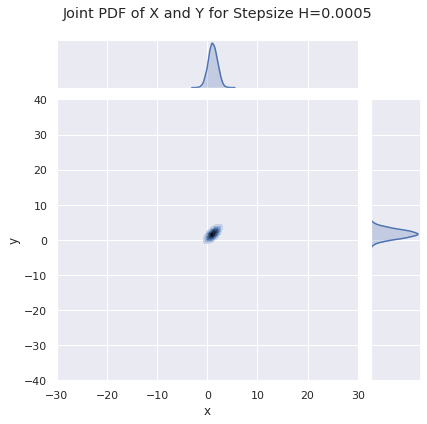

In [22]:
#Plot Joint Probability Distribution for the Random vectors (Pairwise) at different StepSize 
p = sns.jointplot(x=F[0][0],
              y=F[0][1], 
              kind="kde", 
              space=0).set_axis_labels("x", "y")
p.fig.suptitle(f'Joint PDF of X and Y for Stepsize H={h[0]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,40)

(-40.0, 40.0)

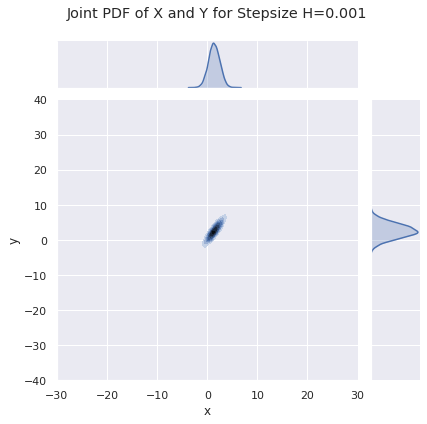

In [26]:
p = sns.jointplot(x=F[1][0],
              y=F[1][1], 
              kind="kde", 
              space=0).set_axis_labels("x", "y")
p.fig.suptitle(f'Joint PDF of X and Y for Stepsize H={h[1]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,40)

(-40.0, 40.0)

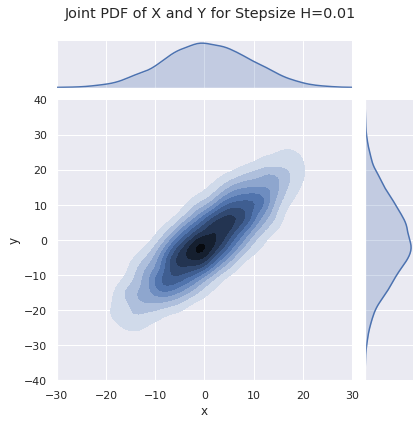

In [27]:
p = sns.jointplot(x=F[2][0],
              y=F[2][1], 
              kind="kde", 
              space=0).set_axis_labels("x", "y")
p.fig.suptitle(f'Joint PDF of X and Y for Stepsize H={h[2]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,40)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1132: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1134: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg,

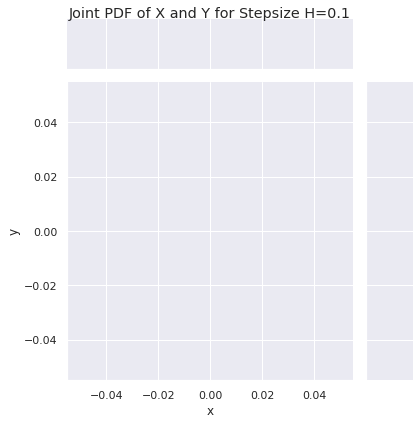

In [28]:
p = sns.jointplot(x=F[3][0],
              y=F[3][1], 
              kind="kde", 
              space=0).set_axis_labels("x", "y")
p.fig.suptitle(f'Joint PDF of X and Y for Stepsize H={h[3]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

For step size H=0.1, run time warning is thrown, due to encounter of infinite or division by a value that arounds to zero, and due to no variance among the functions due to repeating values.

(-40.0, 60.0)

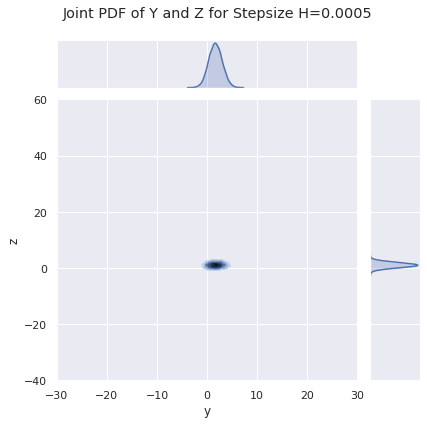

In [29]:
p = sns.jointplot(x=F[0][1],
              y=F[0][2], 
              kind="kde", 
              space=0).set_axis_labels("y", "z")
p.fig.suptitle(f'Joint PDF of Y and Z for Stepsize H={h[0]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,60)

(-40.0, 60.0)

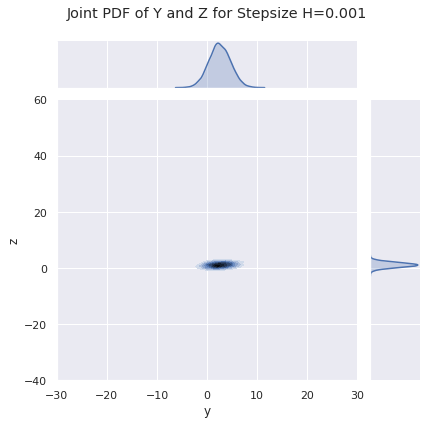

In [30]:
p = sns.jointplot(x=F[1][1],
              y=F[1][2], 
              kind="kde", 
              space=0).set_axis_labels("y", "z")
p.fig.suptitle(f'Joint PDF of Y and Z for Stepsize H={h[1]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,60)

(-40.0, 60.0)

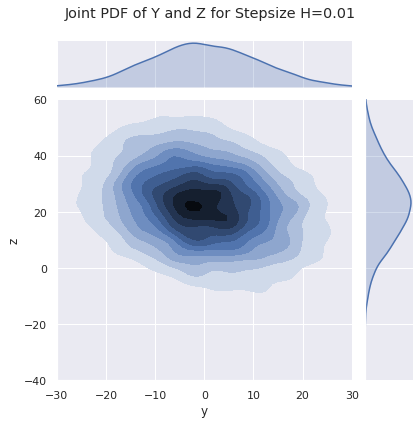

In [31]:
p = sns.jointplot(x=F[2][1],
              y=F[2][2], 
              kind="kde", 
              space=0).set_axis_labels("y", "z")
p.fig.suptitle(f'Joint PDF of Y and Z for Stepsize H={h[2]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,30)
p.ax_marg_y.set_ylim(-40,60)

(-40.0, 40.0)

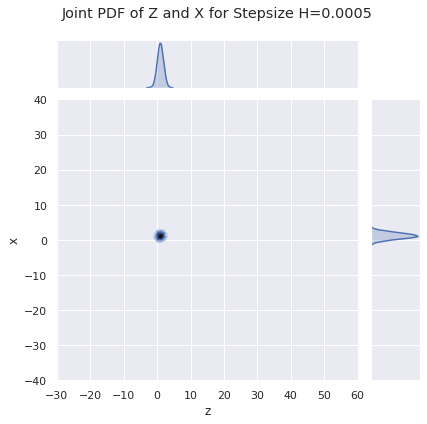

In [32]:
p = sns.jointplot(x=F[0][2],
              y=F[0][0], 
              kind="kde", 
              space=0).set_axis_labels("z", "x")
p.fig.suptitle(f'Joint PDF of Z and X for Stepsize H={h[0]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,60)
p.ax_marg_y.set_ylim(-40,40)

(-40.0, 40.0)

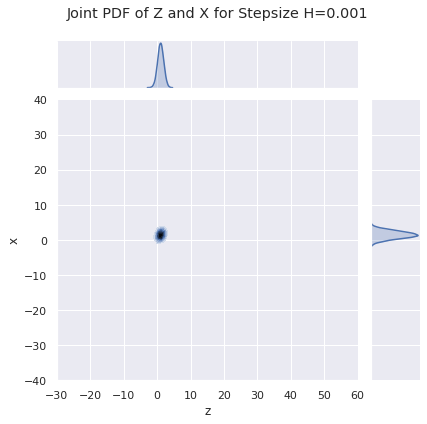

In [33]:
p = sns.jointplot(x=F[1][2],
              y=F[1][0], 
              kind="kde", 
              space=0).set_axis_labels("z", "x")
p.fig.suptitle(f'Joint PDF of Z and X for Stepsize H={h[1]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,60)
p.ax_marg_y.set_ylim(-40,40)

(-40.0, 40.0)

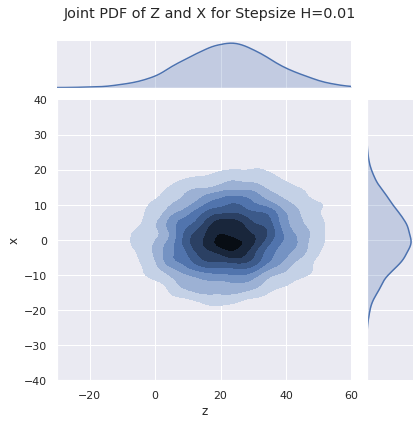

In [34]:
p = sns.jointplot(x=F[2][2],
              y=F[2][0], 
              kind="kde", 
              space=0).set_axis_labels("z", "x")
p.fig.suptitle(f'Joint PDF of Z and X for Stepsize H={h[2]}')
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.9)
p.ax_marg_x.set_xlim(-30,60)
p.ax_marg_y.set_ylim(-40,40)